In [2]:
%matplotlib inline
import torch
import random
from matplotlib import pyplot as plt
from d2l import torch as d2l

In [3]:
# 构造数据集
def synthetic_data(w, b, num_examples):
    """
        生成数据，y = Xw + b + 噪声
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print(f'features: {features[0]}, label:{labels[0]}')

features: tensor([-0.1073, -2.4501]), label:tensor([12.3170])


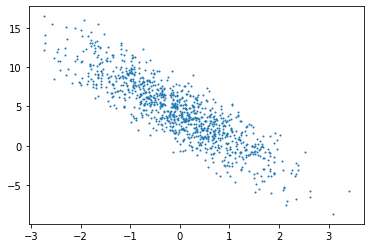

In [11]:
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# detach剥离数据，不包含梯度
# 绘制一个特征与标签的图

In [13]:
# 生成大小为batch_size的数据
def data_iter(batch_size, features, labels):
    """
        数据迭代，将features切成小批量数据
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱数据
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(f'{X}\n{y}')
    break

tensor([[ 1.8959, -0.9541],
        [-1.6748,  0.4073],
        [-1.4407, -0.7680],
        [ 0.1107, -0.7003],
        [-0.1915, -1.2955],
        [ 0.2483, -0.7130],
        [-0.5619,  0.5167],
        [-0.5337, -1.3543],
        [-0.5479, -0.6634],
        [ 0.0487, -0.1776]])
tensor([[11.2342],
        [-0.5400],
        [ 3.9309],
        [ 6.8003],
        [ 8.2162],
        [ 7.1195],
        [ 1.3070],
        [ 7.7418],
        [ 5.3717],
        [ 4.9150]])


In [16]:
def linreg(X, w, b):
    """
        线性回归模型
    """
    return torch.matmul(X, w) + b

In [17]:
def squared_loss(y_hat, y):
    """
        均方误差
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [19]:
def sgd(params, lr, batch_size):
    """
        小批量随机梯度下降
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [36]:
# 初始化模型参数，模型训练
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 小批量损失
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}, w: {w}, b: {b}')

epoch 1, loss 0.025836, w: tensor([[ 1.9257],
        [-3.2978]], requires_grad=True), b: tensor([4.0186], requires_grad=True)
epoch 2, loss 0.000092, w: tensor([[ 1.9971],
        [-3.3973]], requires_grad=True), b: tensor([4.1920], requires_grad=True)
epoch 3, loss 0.000052, w: tensor([[ 1.9996],
        [-3.4000]], requires_grad=True), b: tensor([4.2002], requires_grad=True)
epoch 4, loss 0.000052, w: tensor([[ 2.0001],
        [-3.4003]], requires_grad=True), b: tensor([4.2003], requires_grad=True)
epoch 5, loss 0.000052, w: tensor([[ 1.9998],
        [-3.4005]], requires_grad=True), b: tensor([4.2002], requires_grad=True)


In [21]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 1.4424e-04, -8.7261e-05], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0001], grad_fn=<RsubBackward1>)


In [33]:
###############################
# 线性回归简洁实现
# 使用pytorch框架简洁实现

In [38]:
from torch.utils import data  # 导入pytorch数据处理模块

In [39]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [41]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器

    Defined in :numref:`sec_linear_concise`"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [42]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 1.3127, -0.8296],
         [-0.7062,  2.2287],
         [ 0.5412, -0.0250],
         [ 0.6673,  0.9034],
         [-1.0045, -1.0215],
         [ 0.5905, -0.1857],
         [ 0.2408,  1.2244],
         [-0.6223,  0.2133],
         [-0.8548, -0.8655],
         [-1.1939, -1.6603]]),
 tensor([[ 9.6573],
         [-4.7905],
         [ 5.3661],
         [ 2.4529],
         [ 5.6686],
         [ 5.9981],
         [ 0.5138],
         [ 2.2123],
         [ 5.4359],
         [ 7.4667]])]

In [70]:
from torch import nn

# 将一个2个输入1个输出的线性模型放入构造的网络层序列中
net = nn.Sequential(nn.Linear(2, 1))

# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [71]:
# 均方误差
loss = nn.MSELoss()
# 小批量随机梯度下降
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [72]:
# 训练数据
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        trainer.step()  # 参数更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000237
epoch 2, loss 0.000102
epoch 3, loss 0.000104
epoch 4, loss 0.000102
epoch 5, loss 0.000103
